# 2-Updated Sentiment Analysis情感分析改进

在上一本笔记本中，我们进行了情感分析的基础知识。在此笔记本中，我们实际上将获得不错的结果。

我们将使用：

- 打包填充序列(padded sequences
- 预训练词嵌入(pre-trained word embeddings
- 不同的RNN架构(different RNN architecture
- 双向RNN(bidirectional RNN
- 多层RNN(multi-layer RNN
- 正则化 regularization
- 不同的优化器 optimizer

这将使我们达到〜84％的测试精度。

## 准备数据

### 使用*打包的填充序列 packed padded sequences*

和以前一样，我们将设置种子，定义`Fields`并获得train/valid/test分割。

我们将使用*打包的填充序列 packed padded sequences*，这将使我们的RNN仅处理序列的非填充元素，对于任何填充元素，`output`将为零张量。

要使用打包的填充序列，我们必须告诉RNN实际序列有多长时间。为此，我们为`TEXT`字段设置`include_lengths = True`。这将使`batch.text`现在成为一个元组，第一个元素是我们的句子（已填充的数字化张量），第二个元素是我们句子的实际长度。

In [1]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234 # 随机种子,可重复性

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 先处理数据，处理标签
TEXT = data.Field(tokenize = 'spacy', include_lengths = True) # 打包的填充序列 
# 将数据拆分为离散的字符,tokenize无参数，默认用空格来拆分
LABEL = data.LabelField(dtype = torch.float) # 处理标签

然后，我们加载IMDb数据集。

In [2]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

然后根据我们的训练集创建验证集。

In [3]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

### 使用**预训练的单词嵌入**。

- 使用`"glove.6B.100d" 向量`（`glove`是用于计算向量的算法）

现在，我们不再使用随机初始化单词嵌入的方法，而是使用这些经过预先训练的向量进行初始化。我们只需指定所需的向量（前25000个单词）并将其作为参数传递给`build_vocab`即可获得这些向量。 `TorchText`负责下载矢量并将它们与我们词汇表中的正确单词相关联。

在这里，我们将使用`"glove.6B.100d" 向量"`。`GloVe`是用于计算向量的算法，在 [这里](https://nlp.stanford.edu/projects/glove/) 可以查看更多信息。`6B`表示这些向量在60亿个令牌上训练，而`100d`表示这些向量是100尺寸。

您可以在[此处](https://github.com/pytorch/text/blob/master/torchtext/vocab.py#L113)查看其他可用的向量。

从理论上讲，这些经过预训练的向量在向量空间中已经具有接近语义的词，它们在向量空间中靠得很近。"terrible", "awful", "dreadful" are nearby。这为我们的嵌入层提供了很好的初始化方法，因为它不必从头开始学习这些关系。

**注意**：这些向量约为862MB，因此，如果您的网络连接有限，请当心。

默认情况下，TorchText会将词汇表中的单词初始化，但不会将您预训练的嵌入词中的单词初始化为零。我们不希望这样，而是通过将`unk_init`设置为`torch.Tensor.normal_`来随机初始化它们。现在，这将通过高斯分布来初始化这些单词。

In [4]:
MAX_VOCAB_SIZE = 25_000 # 仅保留前25,000个单词

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

### 创建迭代器

和以前一样，我们创建迭代器，将张量放置在GPU上（如果可用）。

打包填充序列的另一件事是，一批中的所有张量都需要按其长度排序。通过设置`sort_within_batch = True`，可以在迭代器中进行处理。

In [5]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True, # 打包填充序列：一批中的所有张量都需要按长度排序
    device = device)

## 构建模型

该模型具有最剧烈drastic的变化。

### 不同的RNN架构:长期短期记忆网络（LSTM）

- **标准RNN缺点：[梯度消失](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)**
- 比RNN新增了一个单元$c_t$（可变权重）
- LSTM：解决梯度消失，梯度爆炸和长期依赖问题

我们将使用一种称为长期短期记忆（LSTM）的不同RNN体系结构。为什么LSTM比标准RNN更好？标准RNN受[梯度消失](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)的困扰。 

LSTM通过 _cell_ ，$c$的额外循环状态来克服了这一问题。
-cell可以被认为是LSTM的“记忆memory”-并且使用使用多个 _gates_ 来控制信息流入和流出memory的流程。欲了解更多信息，请点击[这里](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)。我们可以简单地将LSTM视为$x_t$, $h_t$和$c_t$的函数，而不仅仅是$x_t$ 和 $h_t$。

$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$

因此，使用LSTM的模型看起来像（省略了嵌入层）：

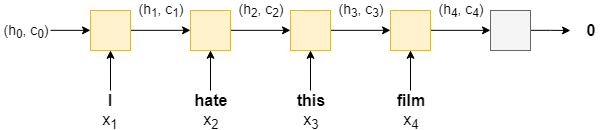

初始单元状态$c_0$，就像初始隐藏状态被初始化为全零的张量一样。然而，情感预测仍然仅使用最终的隐藏状态而不是最终的单元状态进行，即$\hat{y}=f(h_T)$。

### 双向RNN   Bidirectional RNN

双向RNN背后的概念很简单。除了让RNN处理从头到尾的句子中的单词（前向RNN）之外，我们还有第二个RNN处理**从尾数到第一个句子**中的单词（后向RNN）。在时间步$t$，前向RNN是处理字 $x_t$，而后向RNN是处理字$x_{T-t+1}$。

在PyTorch中，由前向和后向RNN返回的隐藏状态（和单元状态）张量彼此堆叠在单个张量中。

我们使用前向RNN（从句子的最后一个词获得）的最后一个隐藏状态的连接$h_T^\rightarrow$，以及反向RNN的最后一个隐藏状态（从句子的第一个单词获得）$h_T^\leftarrow$，来进行情感预测。
即 $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$ 

下图显示了双向RNN，前向RNN为橙色，后向RNN为绿色，线性层为银色。

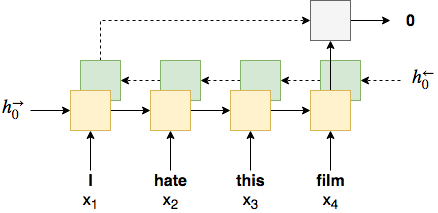

### 多层RNN     Multi-layer RNN

多层RNN（也称为*深度RNN*）是另一个简单的概念。想法是，我们在初始标准RNN之上添加其他RNN，其中添加的每个RNN都是*另一层*。第一个（底部）RNN在时间步$t$输出的隐藏状态在时间步$t$将是其上方RNN的输入。然后根据最终（最高）层的最终隐藏状态进行预测。

下图显示了多层单向RNN，其中层号以上标给出。还要注意，每一层都需要有自己的初始隐藏状态，$h_0^L$。



### 正则化 dropout

- 提高泛化能力

尽管我们对模型进行了改进，但每个模型都添加了其他参数。无需过多地拟合细节，模型中的参数越多，模型过度拟合的可能性就越高（记忆训练数据，导致较低的训练误差，但较高的验证/测试误差，即对新的，未看间的数据的泛化性差）。

为了解决这个问题，我们使用正则化。更具体地说，我们使用一种称为*dropout*的正则化方法。Dropout是在forward过程中随机*dropping out*（设置为0）层中的神经元来进行的。每个神经元dropped out的概率由一个超参数设置，而每个应用了退出的神经元都被独立考虑。关于Dropout为何起作用的一种理论是，可以将具有退出参数的模型视为“弱”（较少参数）模型。所有这些“较弱”模型的预测（每个前向通过一个）在模型参数内平均在一起。因此，可以将您的一个模型视为较弱的模型的集合，这些模型都不是过度参数化的，因此不应过度拟合。

### 实施细节

此模型的另一个补充是，我们将不会学习`<pad>`令牌的嵌入。这是因为我们要明确地告诉我们的模型，填充标记与确定句子的情感无关。这意味着填充令牌的嵌入将保留为其初始化的位置（我们稍后将其初始化为全零）。为此，我们将pad令牌的索引作为`padding_idx`参数传递给`nn.Embedding`层。

要使用LSTM代替标准RNN，我们使用`nn.LSTM`代替`nn.RNN`。另外，请注意，LSTM返回输出`output`和最终隐藏`hidden`状态以及最终单元`cell`状态的元组，而标准RNN仅返回输出`output`和最终隐藏`hidden`状态。

由于LSTM的最终隐藏状态同时具有前向和后向分量，它们将被串联在一起，因此`nn.Linear`层的输入大小是隐藏维大小的两倍。

通过传递`num_layers`的值和RNN / LSTM的双向`bidirectional`参数来实现双向性并添加其他层。

删除是通过初始化`nn.Dropout`层（参数是删除每个神经元的概率）并在我们要对其应用删除的每一层之后在`forward`方法中使用它来实现的。

**注意**：永远不要在输入或输出层（在这种情况下为`text`或`fc`）上使用dropout，而只想在中间层上使用`dropout`。 LSTM有一个`dropout`参数，该参数在一层中的隐藏状态与下一层中的隐藏状态之间的连接上增加了dropout。

当我们传递句子的长度以使用打包的填充序列时，我们必须添加第二个参数`text_lengths`进行转发`forward`。

在将嵌入传递给RNN之前，需要对它们进行打包，这需要使用`nn.utils.rnn.packed_padded_sequence`进行。这将导致我们的RNN仅处理序列中未填充的元素。然后，RNN将返回`packed_output`（打包序列）以及隐藏`hidden`状态和单元`cell`状态（均为张量）。如果没有打包的填充序列，则隐藏`hidden`和单元`cell`是序列中最后一个元素的张量，这很可能是填充令牌，但是，当使用打包的填充序列时，它们都来自序列中最后一个非填充的元素。

然后，我们使用`nn.utils.rnn.pad_packed_sequence`解压缩输出序列，以将其从压缩序列转换为张量。填充令牌的输出`output`元素将为零张量（每个元素为零的张量）。通常，只有在以后在模型中使用输出时，才需要解压缩输出。尽管我们不是在这种情况下，但是我们仍然将序列拆包只是为了展示它是如何完成的。

最终隐藏`hidden`状态为 _**[num layers * num directions, batch size, hid dim]**_。

这些是有序的：**[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]**。当我们想要最后（顶层）向前和向后的隐藏状态时，我们从第一个维度获取了最顶层的两个隐藏层，即`hidden[-2,:,:]`和`hidden[-1,:,:]`，并将它们连接起来在将它们传递到线性层之前（应用dropout之后）在一起。

In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

像以前一样，我们将创建RNN类的实例，并使用新的参数和参数来表示层数，双向性和丢失概率。

为了确保可以将预先训练的向量加载到模型中，`EMBEDDING_DIM`必须等于之前加载的预先训练的GloVe向量。

我们从词汇表中获取填充令牌索引，从字段的`pad_token`属性（默认为`<pad>`）中获取表示填充令牌的实际字符串。

In [7]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

我们将打印出模型中的参数数量。

请注意，我们的参数几乎是以前的两倍！

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


最后的添加是将我们之前加载的预训练词嵌入复制到模型的`embedding`层中。

我们从字段的vocab中检索嵌入，并检查它们的大小是否正确，_**[vocab size, embedding dim]**_ 

In [9]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


We then replace the initial weights of the `embedding` layer with the pre-trained embeddings.

**Note**: this should always be done on the `weight.data` and not the `weight`!

然后，我们用预训练的嵌入替换`embedding`层的初始权重。

**注意**：这应该始终在`weight.data`而不是`weight`上完成！

In [10]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0174, -0.8317,  1.0815,  ..., -0.1634, -0.1672, -0.4210],
        [ 0.3357, -0.6065, -0.4592,  ...,  1.0952,  0.2525, -0.7633],
        [ 0.5939,  0.4972,  0.2567,  ..., -0.5814, -0.0688,  0.6311]])

作为我们的`<UNK>`和`<pad>`令牌不在他们一直在使用`unk_init`初始化的预训练的词汇(一个 $\mathcal{N}(0,1)$ 分布)。最好将它们都初始化为全零，以明确地告诉我们的模型，最初，它们与确定情绪无关。

为此，我们可以手动将嵌入权重矩阵中的行设置为零。我们通过找到标记的索引来获得它们的行，这对于填充索引已经完成。

**注意**：就像初始化嵌入一样，这应该在`weight.data`而不是`weight`上完成！

In [11]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0174, -0.8317,  1.0815,  ..., -0.1634, -0.1672, -0.4210],
        [ 0.3357, -0.6065, -0.4592,  ...,  1.0952,  0.2525, -0.7633],
        [ 0.5939,  0.4972,  0.2567,  ..., -0.5814, -0.0688,  0.6311]])


现在，我们可以看到嵌入权重矩阵的前两行已设置为零。当我们经过垫的指数令牌嵌入层的`padding_idx`将保持零整个训练，但是`<UNK>`标记嵌入将被教训。

## Train the Model

现在来训练模型。

我们在此所做的唯一更改是将优化程序从`SGD`更改为`Adam`。 SGD使用相同的学习速率来更新所有参数，并且选择此学习速率可能很棘手。 `Adam`调整每个参数的学习率，从而使更新频率更高的参数具有较低的学习率，而更新频率较低的参数则具有较高的学习率。有关`Adam`（和其他优化程序）的更多信息，请参见 [此处](http://ruder.io/optimizing-gradient-descent/index.html)。

要将`SGD`更改为`Adam`，我们只需将`optim.SGD`更改为`optim.Adam`，还要注意，由于PyTorch指定了合理的默认初始学习率，因此我们不必为Adam提供初始学习率。

In [12]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

训练模型的其余步骤保持不变。

我们定义标准并将模型和标准放置在GPU上（如果可用）...

In [13]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

我们实现了计算准确性的功能...

In [14]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

我们定义了一个训练模型的函数。

当我们设置`include_lengths = True`时，我们的`batch.text`现在是一个元组，第一个元素是数字化的张量，第二个元素是每个序列的实际长度。在将它们传递给模型之前，我们将它们分为各自的变量`text`和`text_lengths`。

**注意**：由于我们现在正在使用Dropout，因此必须记住使用`model.train()`来确保在训练过程中“打开” dropout。

In [15]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

然后，我们定义一个用于测试模型的函数，再次记住要分开`batch.text`。

**注意**：由于我们现在正在使用Dropout，因此必须记住要使用`model.eval()`来确保在评估时已“关闭” dropout。

In [16]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

并创建一个不错的函数来告诉我们各个epochs要花多长时间。

In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

最后，我们训练模型...

In [18]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 514m 34s
	Train Loss: 0.656 | Train Acc: 61.44%
	 Val. Loss: 0.706 |  Val. Acc: 49.03%
Epoch: 02 | Epoch Time: 493m 46s
	Train Loss: 0.643 | Train Acc: 61.03%
	 Val. Loss: 0.668 |  Val. Acc: 58.77%
Epoch: 03 | Epoch Time: 502m 19s
	Train Loss: 0.661 | Train Acc: 60.19%
	 Val. Loss: 0.649 |  Val. Acc: 60.17%
Epoch: 04 | Epoch Time: 480m 55s
	Train Loss: 0.474 | Train Acc: 77.80%
	 Val. Loss: 0.360 |  Val. Acc: 85.47%
Epoch: 05 | Epoch Time: 455m 22s
	Train Loss: 0.323 | Train Acc: 86.73%
	 Val. Loss: 0.320 |  Val. Acc: 87.31%


...并获得我们全新的，大大提高的测试准确性！

In [19]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.324 | Test Acc: 86.82%


## 用户输入

现在，我们可以使用我们的模型来预测我们给出的任何句子的情绪。由于已经接受了电影评论方面的培训，因此提供的句子也应该是电影评论。

使用模型进行推理时，应始终处于评估模式。如果循序渐进地遵循了本教程，那么它应该已经处于评估模式（对测试集进行评估`evaluate`），但是我们明确设置了它以避免任何风险。

我们的`predict_sentiment`函数可以执行以下操作：

- 将模型设置为评估模式
- 将句子标记化，即将其从原始字符串拆分为标记列表
- 通过将词汇转换为它们的整数表示来索引这些令牌
- 得到我们序列的长度
- 将作为Python列表的索引转换为PyTorch张量
- 通过解压`unsqueeze`添加批次尺寸
- 将长度转换为张量
- 使用`sigmoid`函数压缩0到1之间的实数的输出预测
- 使用`item()`方法将持有单个值的张量转换为整数

我们期望带有负面情绪的评论返回接近0的值，而正面评价则返回接近1的值。

In [20]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

一个负面评价示例...

In [21]:
predict_sentiment(model, "This film is terrible")

0.22547456622123718

一个正面评价示例...

In [22]:
predict_sentiment(model, "This film is great")

0.9530301690101624

## 下一步

我们现在为电影评论建立了一个体面的情感分析模型！在下一个笔记本中，我们将实现一个模型，该模型将以较少的参数获得差不多的精度，并且训练速度快得多。